In [1]:
import sys
import inspect
import os
import numpy as np
import pandas as pd
import math
import bisect
import matplotlib.pyplot as plt
import seaborn as sb
import ast
from scipy import stats as st

In [2]:
trials = pd.read_csv("./data/celine/main/trials.csv")

In [3]:
trials_force_answer = (trials[['trial_burst_force', 'trial_burst_time','subj_answer']][trials['subj_answer'].notnull()])
trials_force_answer["trial_burst_force"] = trials_force_answer["trial_burst_force"].abs()

## Burst force und subjective answer

In [4]:
# Korrelation zwischen burst force und subjective answer berechnen
res_force_answer_spearmanr = st.spearmanr(trials_force_answer['trial_burst_force'].abs(), trials_force_answer['subj_answer'])
print(f"Korr zwischen |burst_force| und subjective answer:\n{res_force_answer_spearmanr}")

# Permutation test for p because of small batch size
def statistic(x):  # permute only `x`
    return st.spearmanr(x, trials_force_answer['subj_answer']).statistic
res_exact = st.permutation_test((trials_force_answer['trial_burst_force'].abs(),), statistic, permutation_type='pairings')
print(f"Permutation test p-Wert: {res_exact.pvalue}\n")

res_time_answer_spearmanr = st.spearmanr(trials_force_answer['trial_burst_time'], trials_force_answer['subj_answer'])
print(f"Korr zwischen |burst_time| und subjective answer:\n{res_time_answer_spearmanr}")

Korr zwischen |burst_force| und subjective answer:
SignificanceResult(statistic=0.35785359325419386, pvalue=3.010700760038783e-07)
Permutation test p-Wert: 0.0002

Korr zwischen |burst_time| und subjective answer:
SignificanceResult(statistic=0.30762814191143206, pvalue=1.2808282103468508e-05)


In [18]:
# TODO: corr accross participants

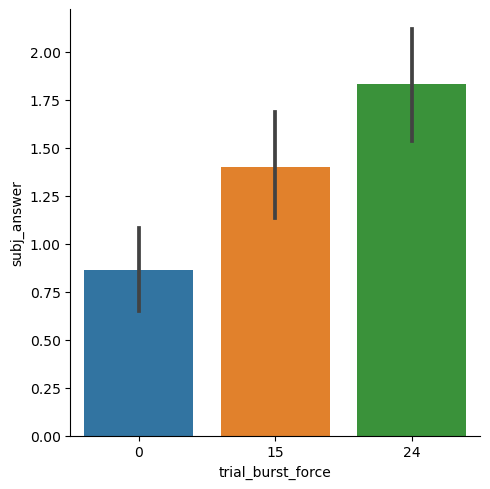

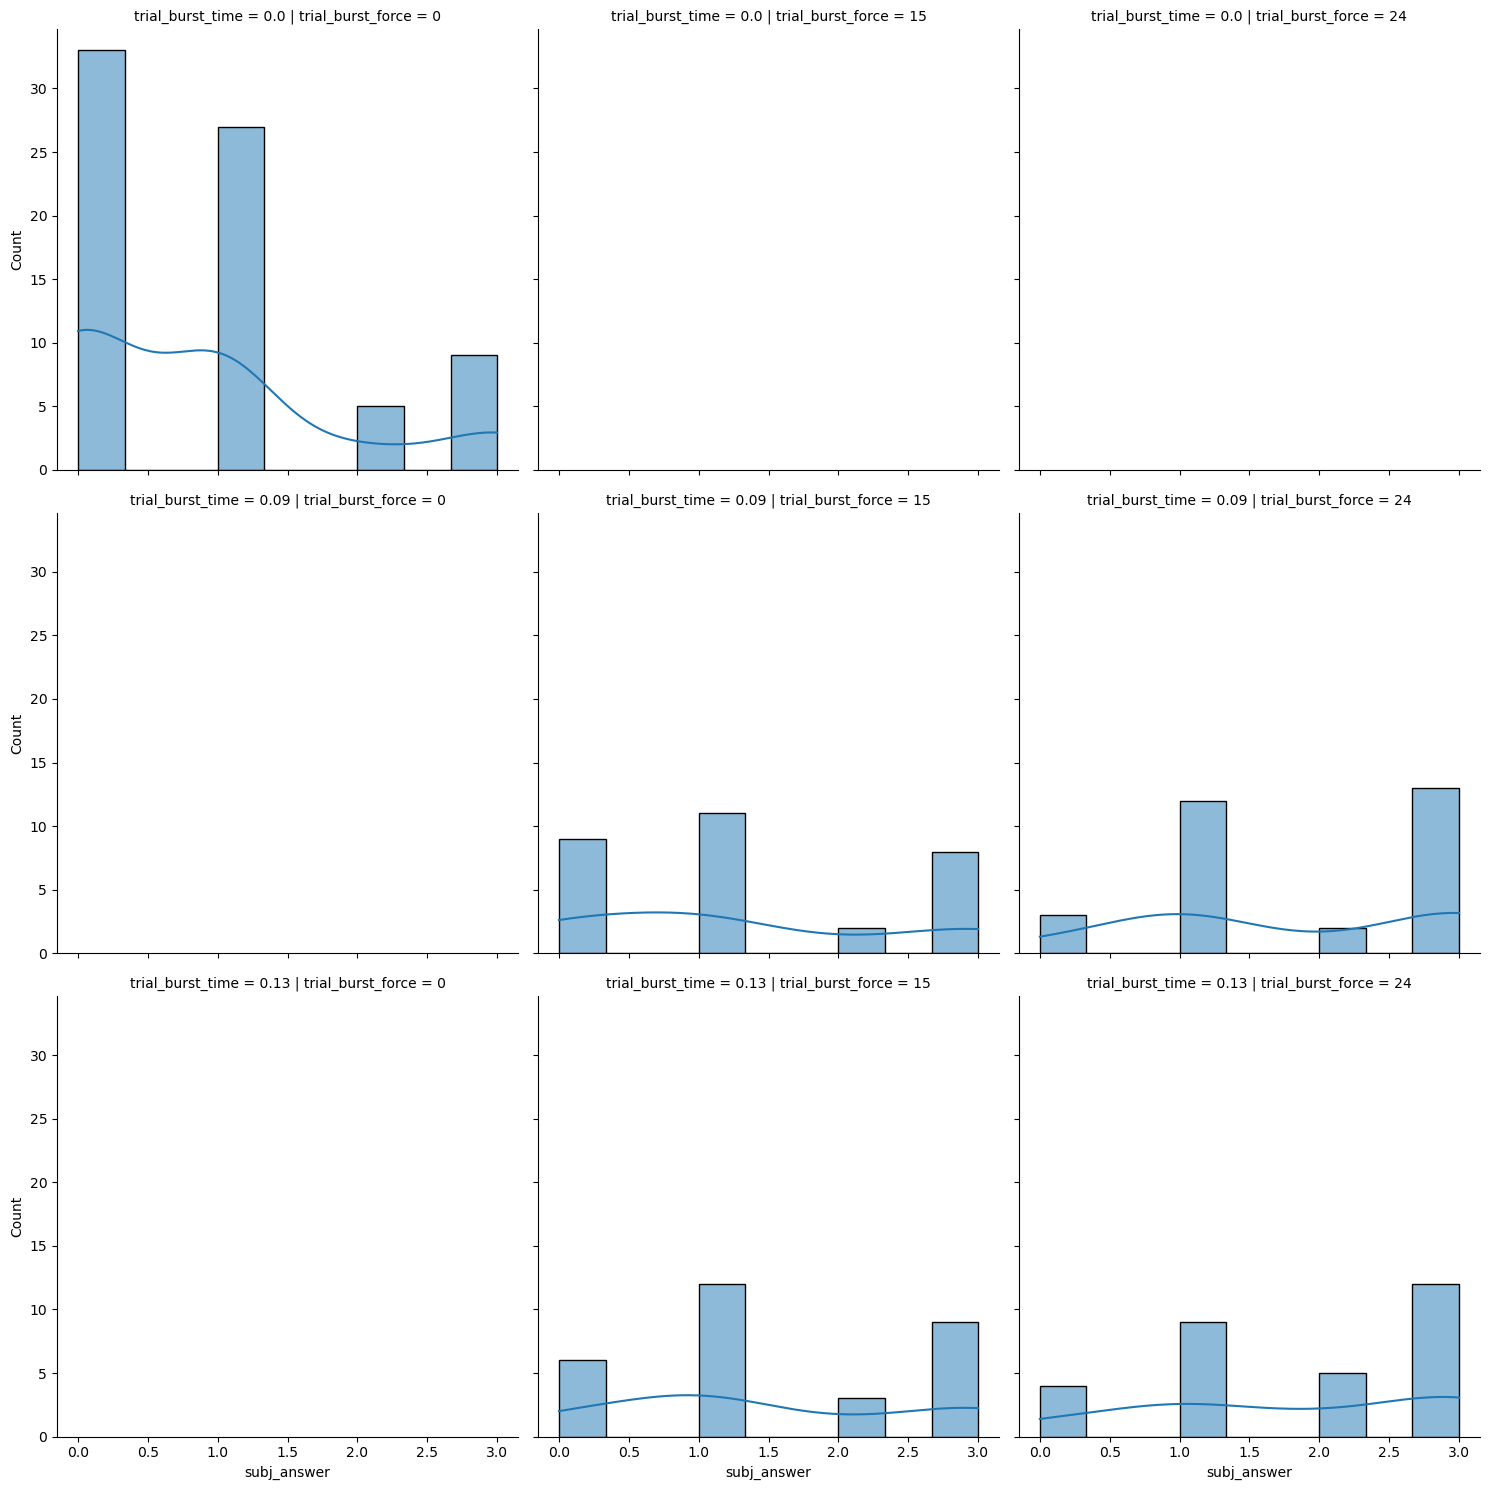

In [5]:
# Histogramme
sb.catplot(data=trials_force_answer, kind="bar", x="trial_burst_force", y="subj_answer")
# COM: there is some variation for problems like this. (log-odds stuffs)

# COM:ned unbedingt nötig
trials_force_answer_bin = trials_force_answer.copy()
trials_force_answer_bin['trial_burst_force'] = trials_force_answer_bin.trial_burst_force.apply(lambda x: 1 if x > 0 else 0)
sb.displot(data=trials_force_answer, x="subj_answer", col="trial_burst_force", row="trial_burst_time", kde=True)

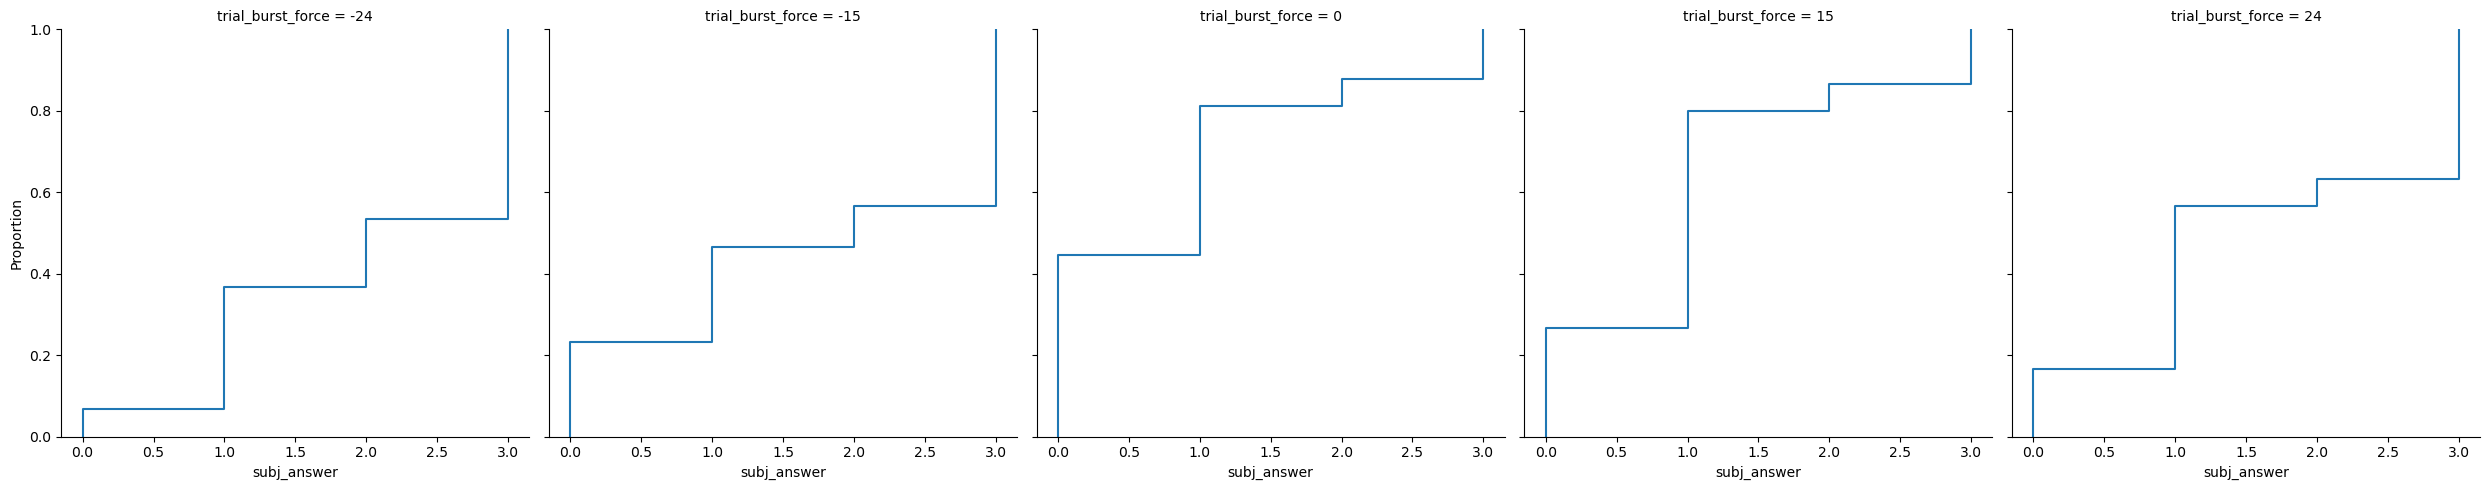

In [6]:
sb.displot(data=trials, x="subj_answer", col="trial_burst_force", kind="ecdf")
# COM: may be put into a test straight away

## Trajectory

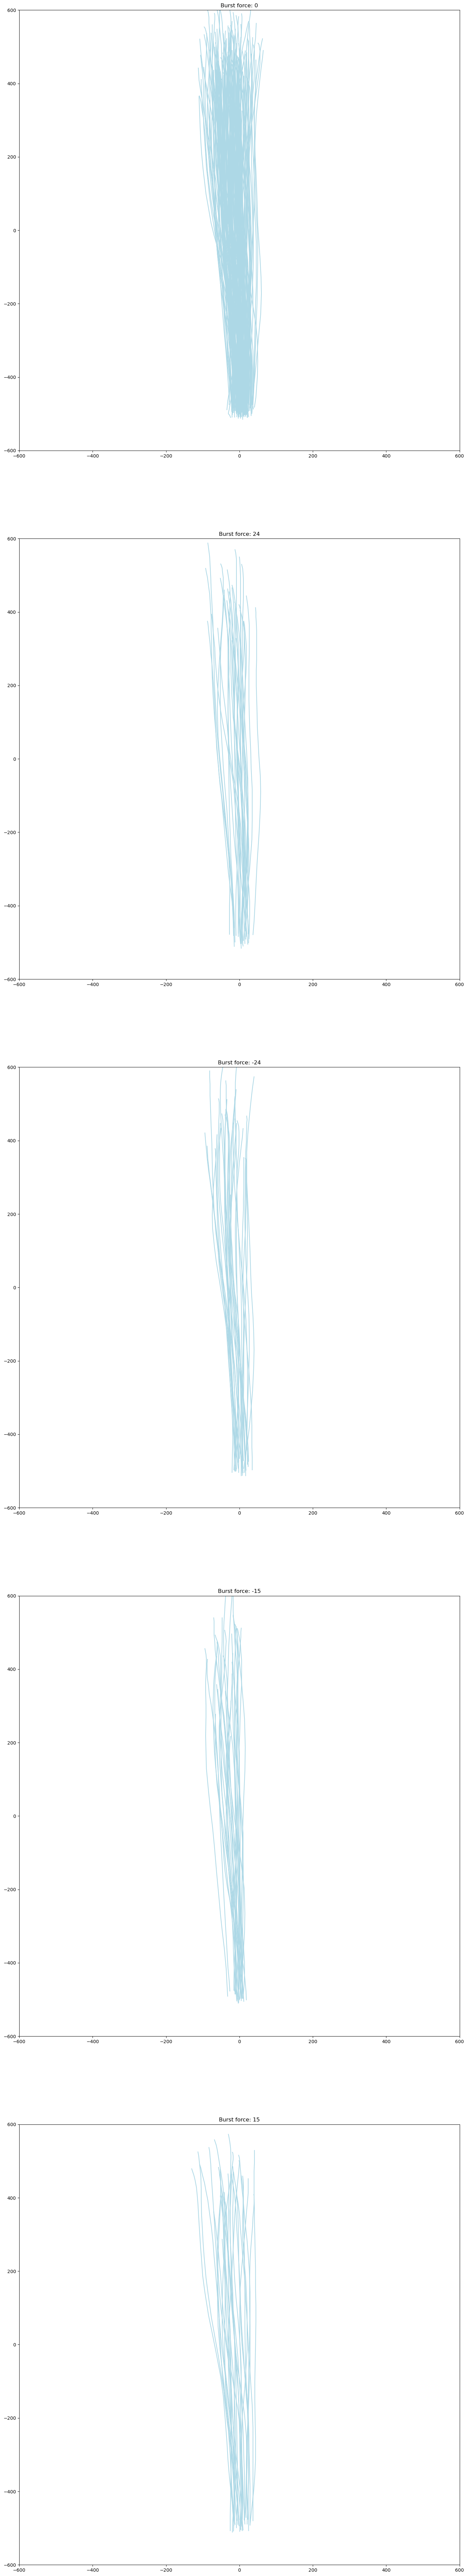

In [7]:
# TODO: das mit seaborn machen (neues df erstellen und daten dort reinlesen)
cols = trials["trial_burst_force"].unique()
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=len(cols), ncols=1)
#fig.subplots_adjust(hspace=10)
fig.set_figheight(100)
fig.set_figwidth(100)
axs = [ax1, ax2, ax3, ax4, ax5]
for i, ax in enumerate(axs):
    ax.set_xlim(-600,600)
    ax.set_ylim(-600,600)
    ax.set_aspect(1)
    ax.set_title(f"Burst force: {cols[i]}")
for _, t in trials.iterrows():
    idx = np.where(cols == t['trial_burst_force'])[0][0]
    path = np.stack(np.load(f"./data/celine/main/b{t['block_nr']}_t{t['trial_nr']}_fm.npy", allow_pickle=True)[0], axis=0)
    axs[idx].plot(path[:,0], path[:,1], color='lightblue')

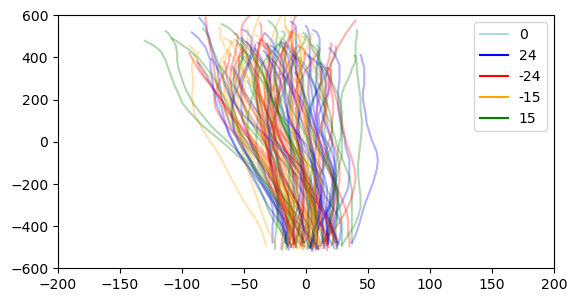

In [20]:
colors = ['lightblue', 'blue', 'red', 'orange', 'green']
for c,l in zip(colors, cols):
    plt.plot(0,0,color=c, label=l)
for _, t in trials.iterrows():
    if t['trial_burst_force'] != 0:
        idx = np.where(cols == t['trial_burst_force'])[0][0]
        path = np.stack(np.load(f"./data/celine/main/b{t['block_nr']}_t{t['trial_nr']}_fm.npy", allow_pickle=True)[0], axis=0)  # TODO: virtual pos plotten [2]
        plt.plot(path[:,0], path[:,1], color=colors[idx], alpha=0.3)
        
        # COM: wenn pfade sich ned so verändern vllt sogar gut weil dann weiß man sensation kommt nicht von anpassen.
# TODO? average path when no distortion...
# Average paths generell  # COM: resample (normalize in time or in space?), interpolate and then average. (Remove outliers first (too slow f.e.))
# Maybe get start and end point with a velocity measure? Maybe top_pos[1] as endpoint
    
plt.xlim(-200,200)
plt.ylim(-600, 600)
plt.gca().set_aspect(0.17)
plt.legend()


## EDA data

In [ ]:
# COM: look again at how to measure EDA

/home/croniev/anaconda3/envs/levinana/lib/python3.9/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


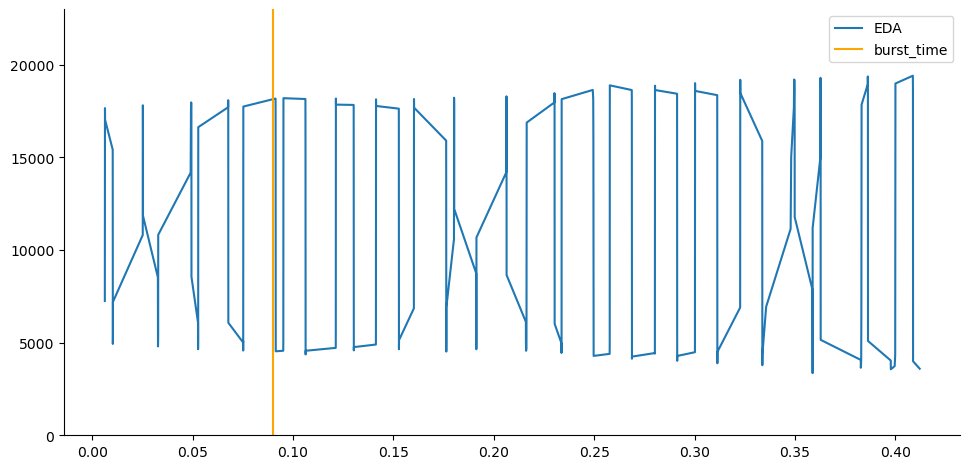

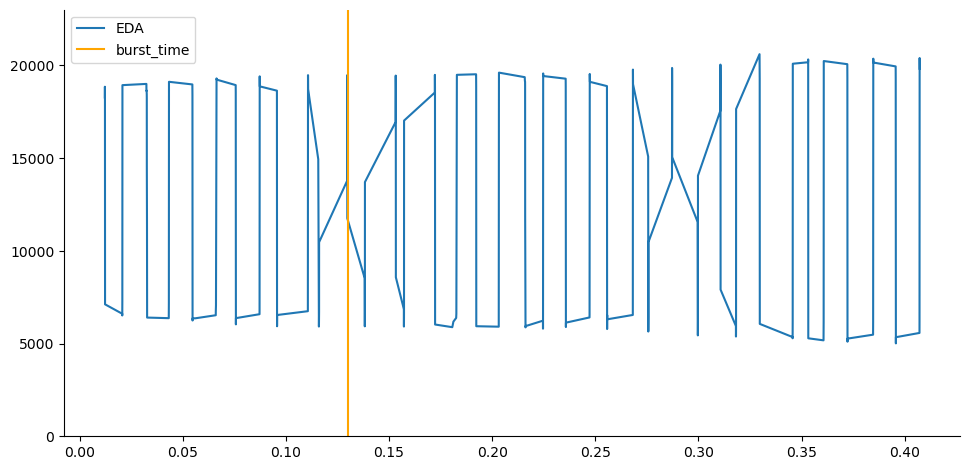

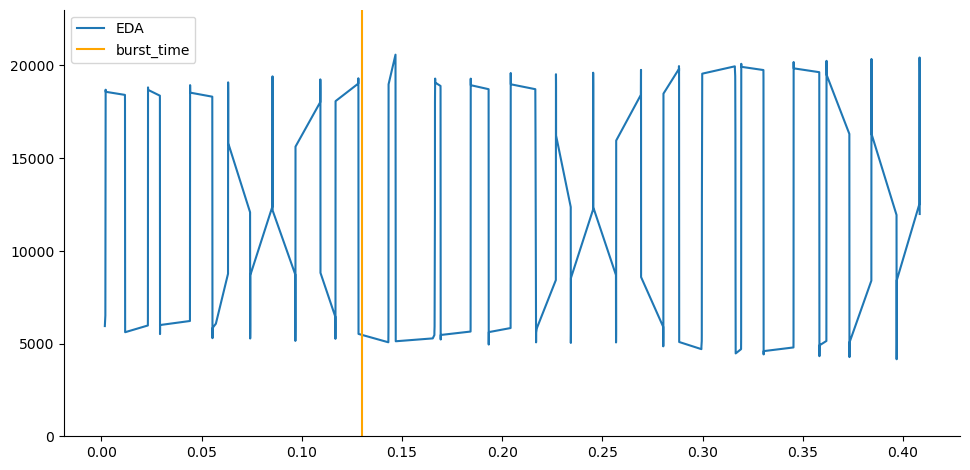

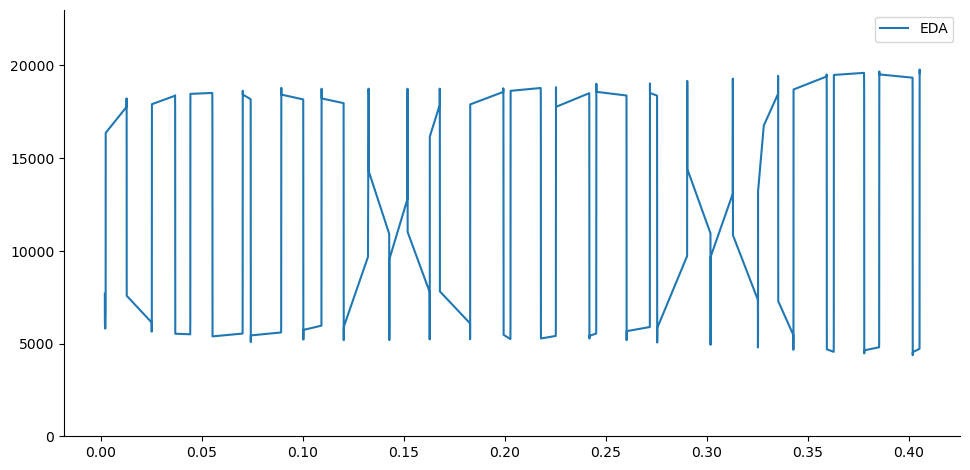

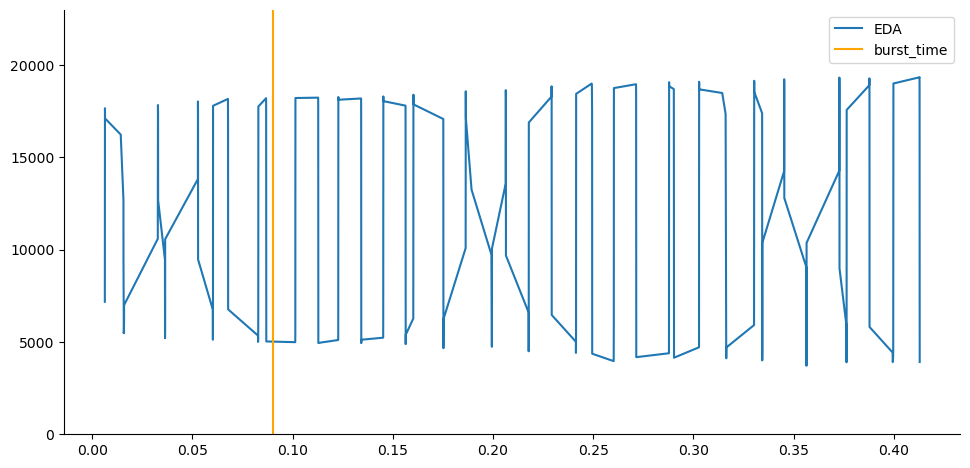

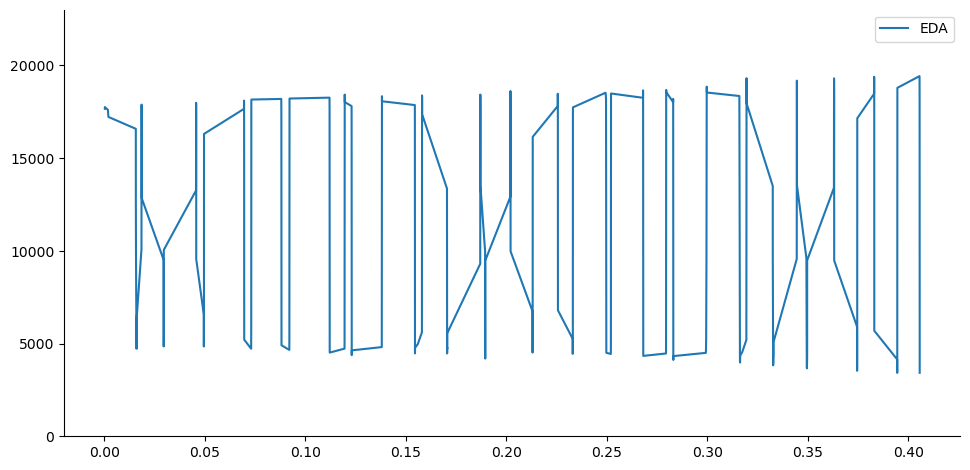

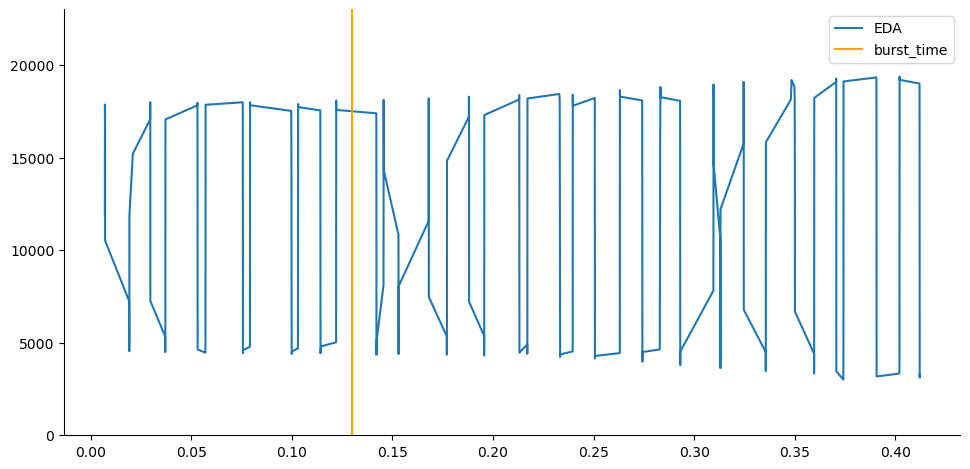

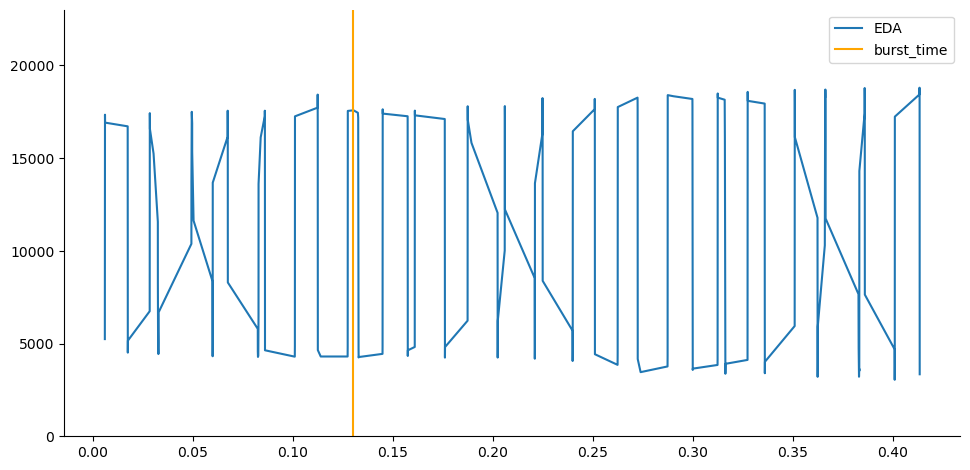

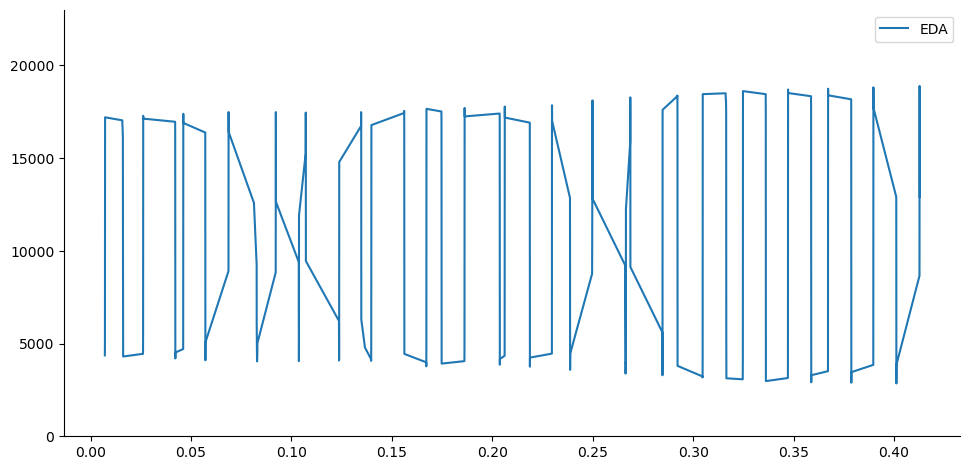

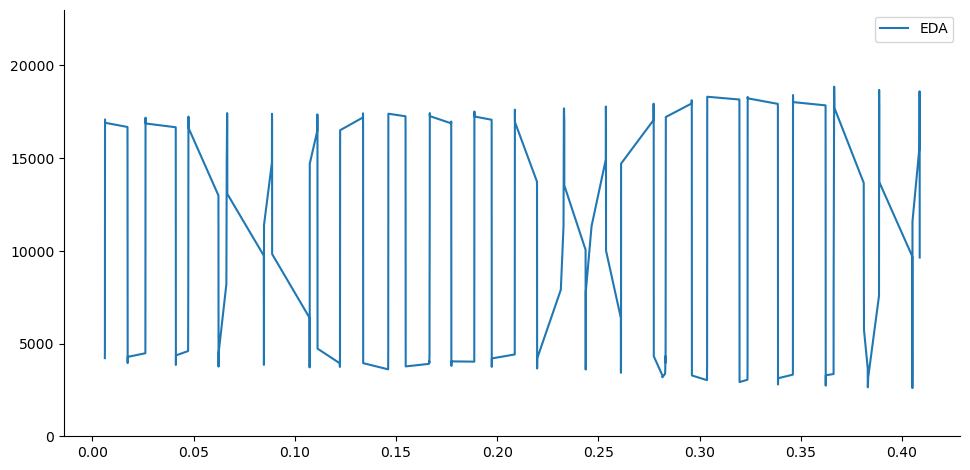

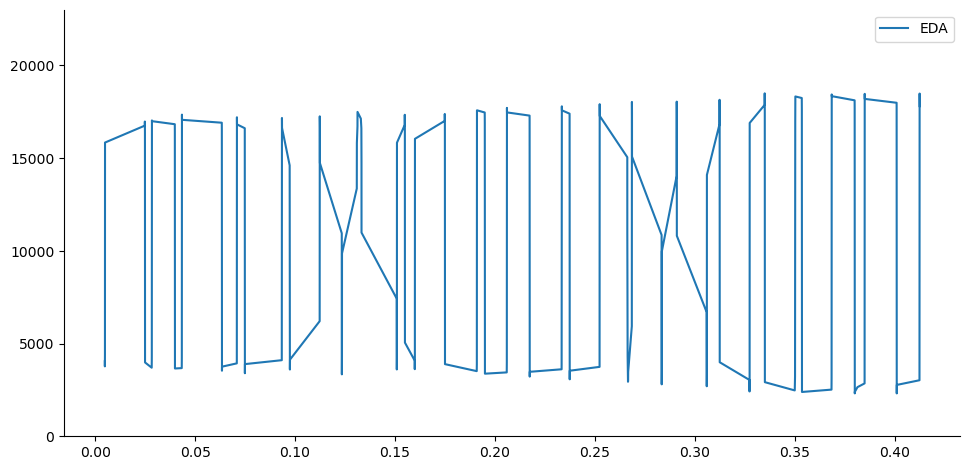

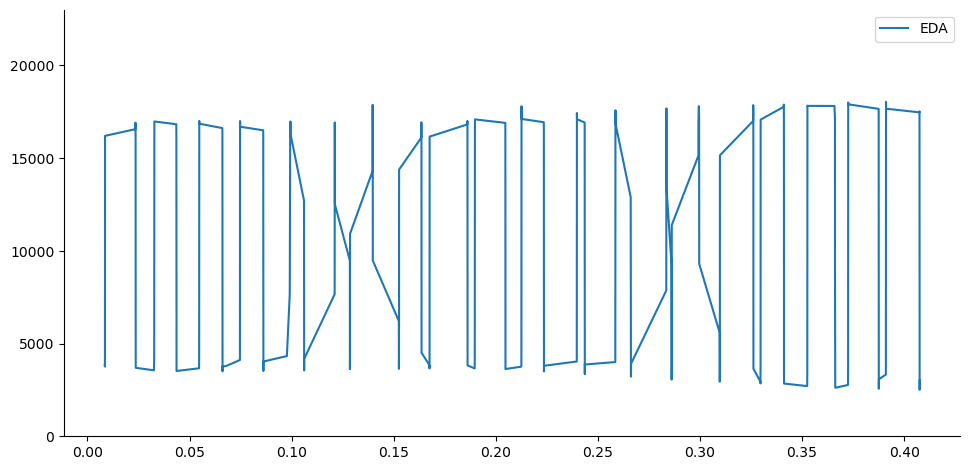

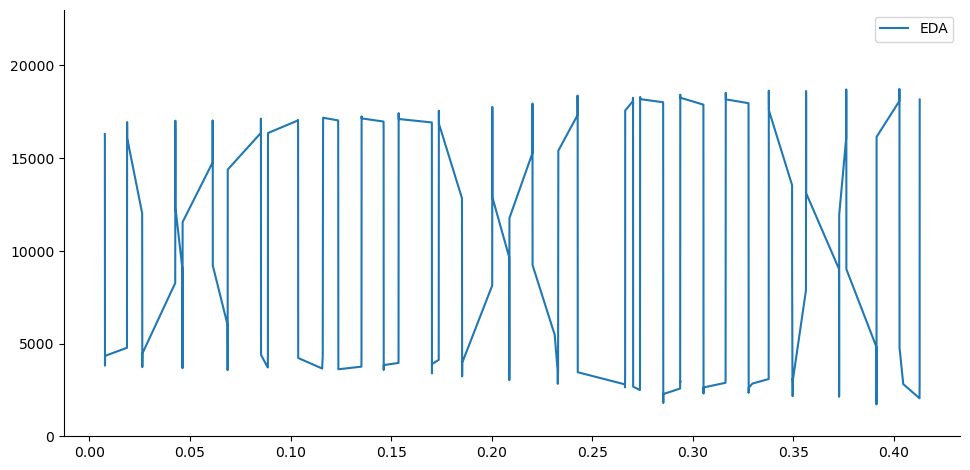

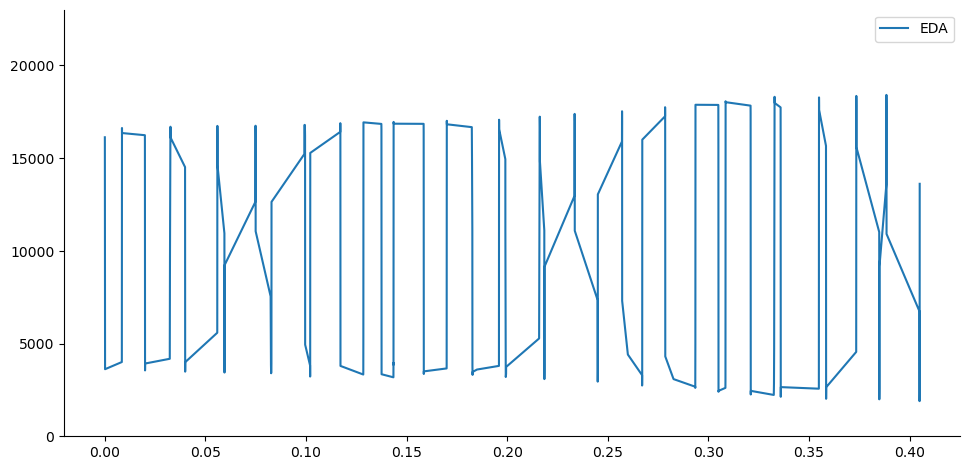

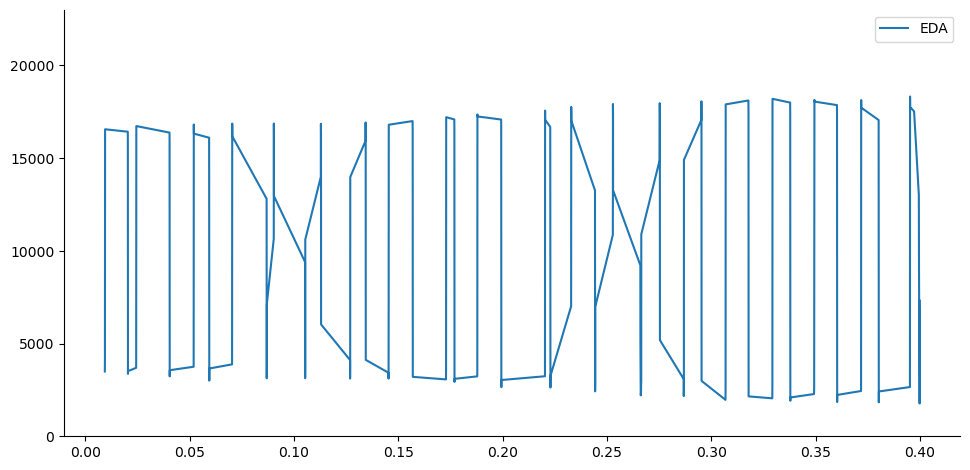

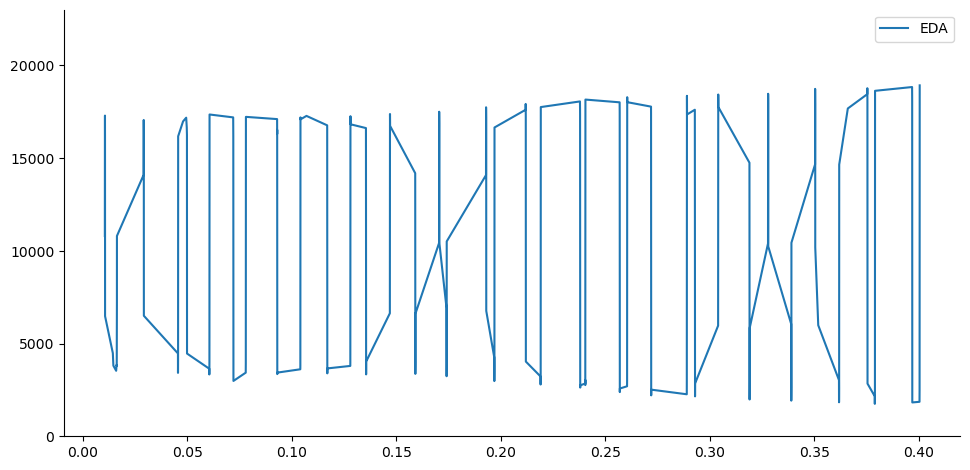

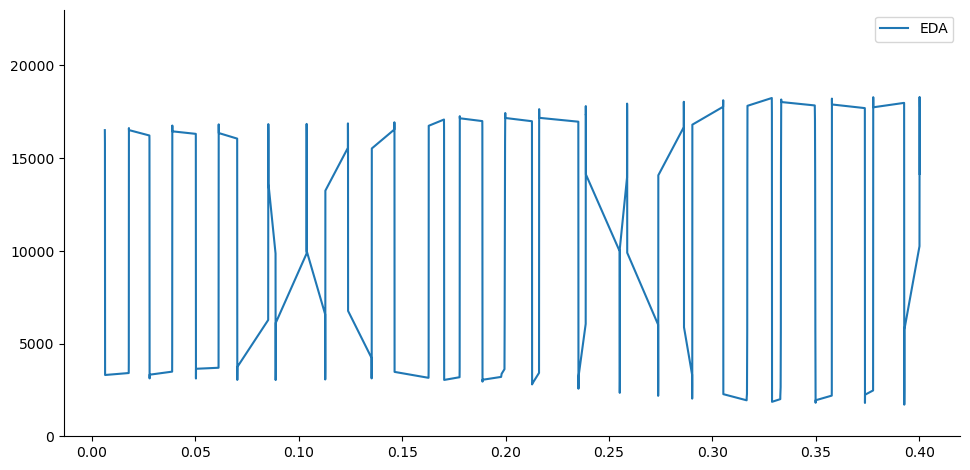

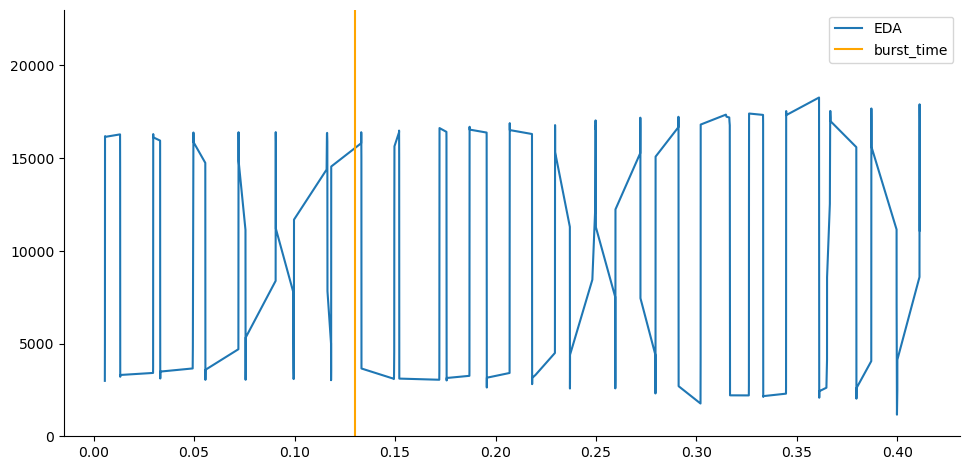

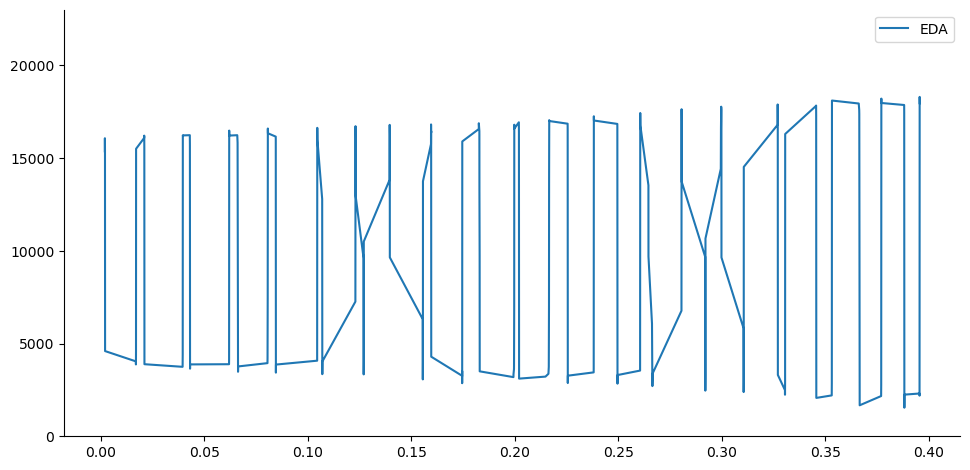

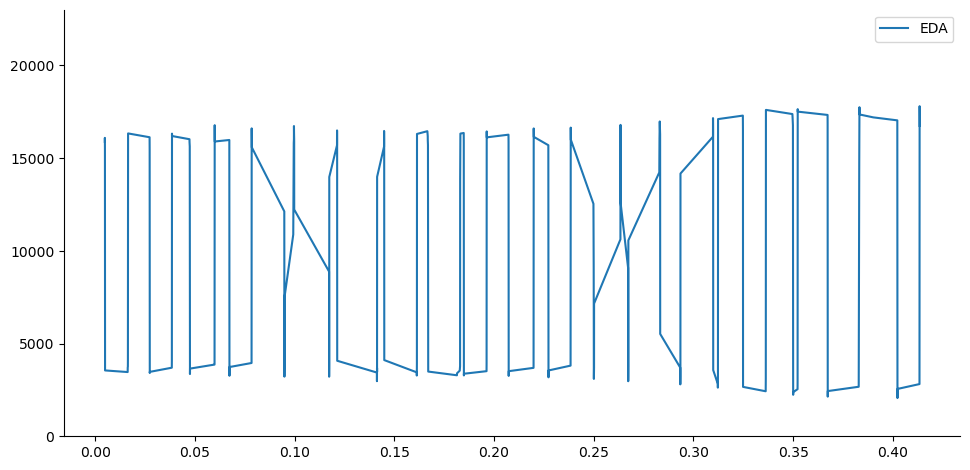

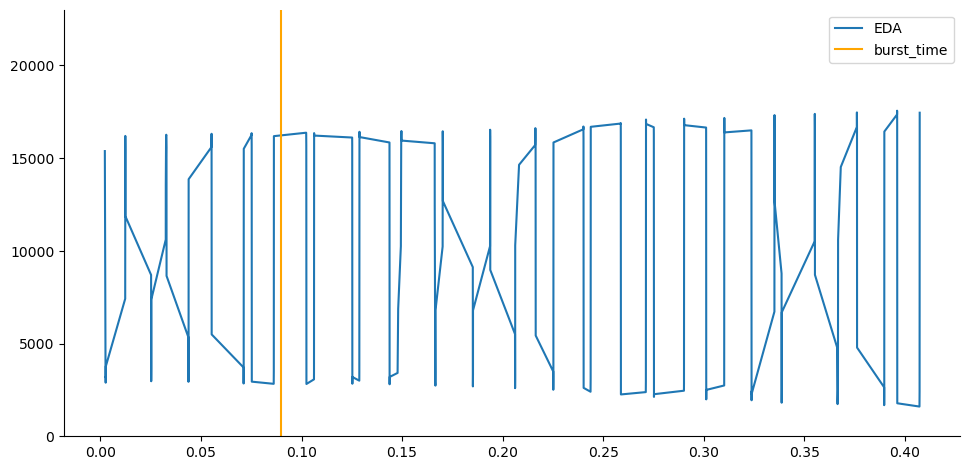

In [9]:
# Plot EDA data with burst_time
for i, t in trials.iterrows():
    if i < 20 or i> 40:
        continue
    eda_data = np.load(f"./data/celine/main/b{t['block_nr']}_t{t['trial_nr']}_fe.npy", allow_pickle=True)
    #f_data = np.load(f"./data/celine/main/b{t['block_nr']}_t{t['trial_number']}_fm.npy")
    
    t_plt = sb.relplot(kind="line", x=eda_data[1][0], y=eda_data[0][0], aspect=2, label="EDA")
    t_plt.set(ylim=(0, 23000))
    if t['trial_burst_time'] != 0:
        plt.axvline(x=t['trial_burst_time'], color='orange', label="burst_time")
        
    plt.legend()

/home/croniev/anaconda3/envs/levinana/lib/python3.9/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


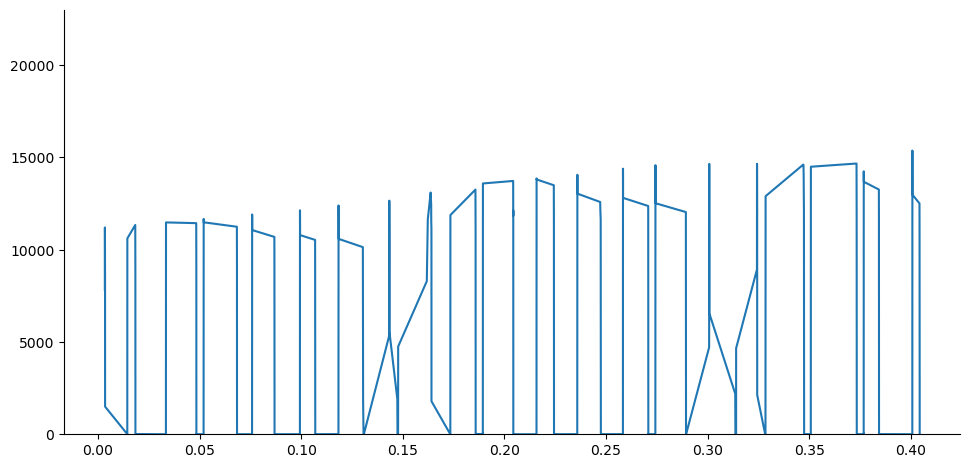

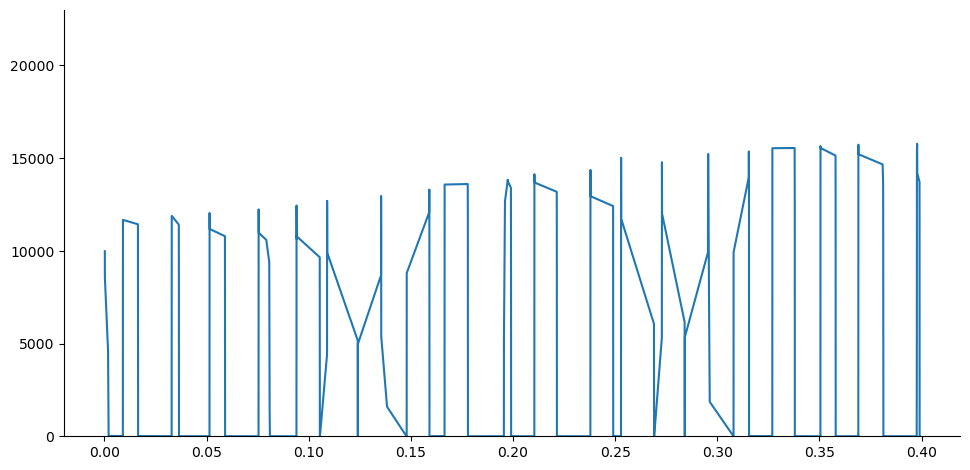

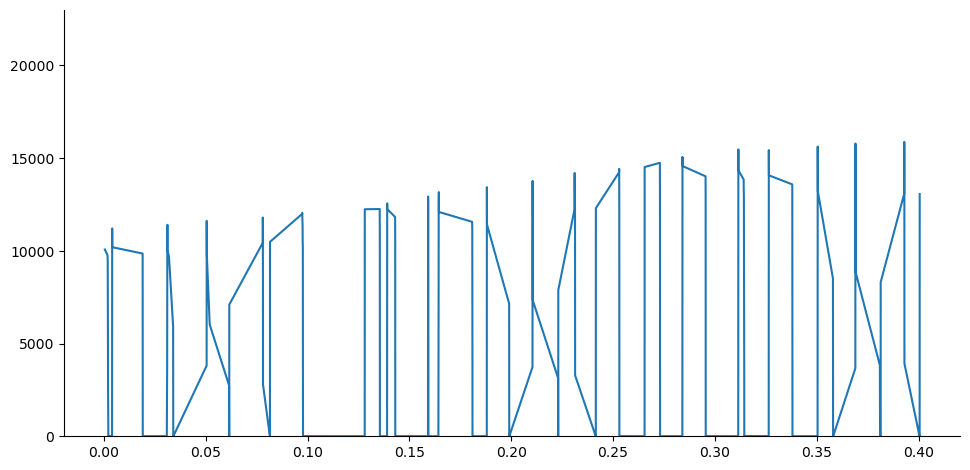

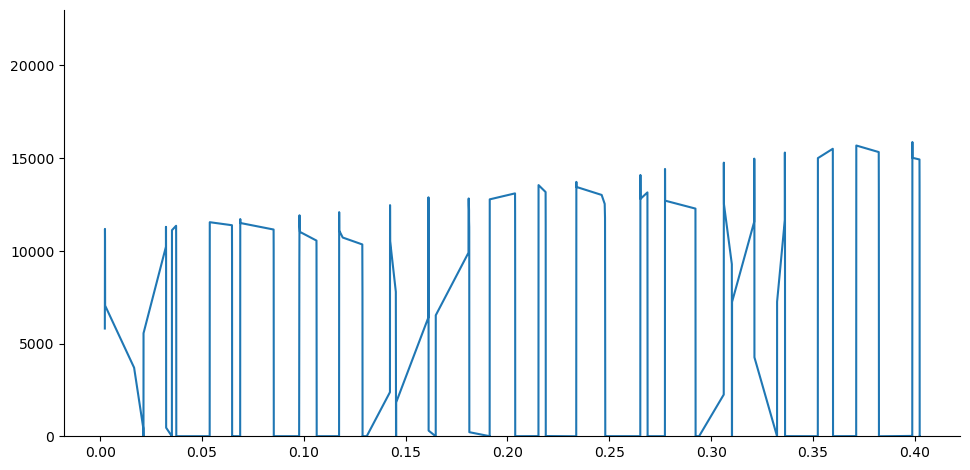

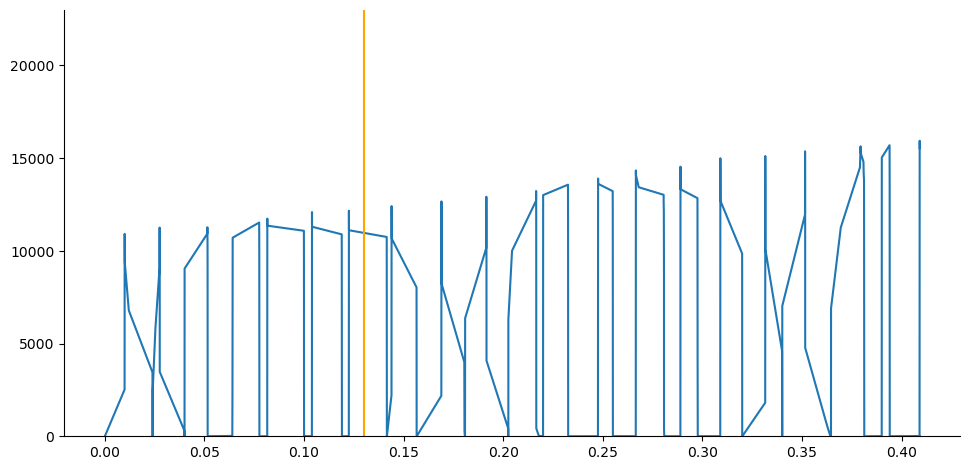

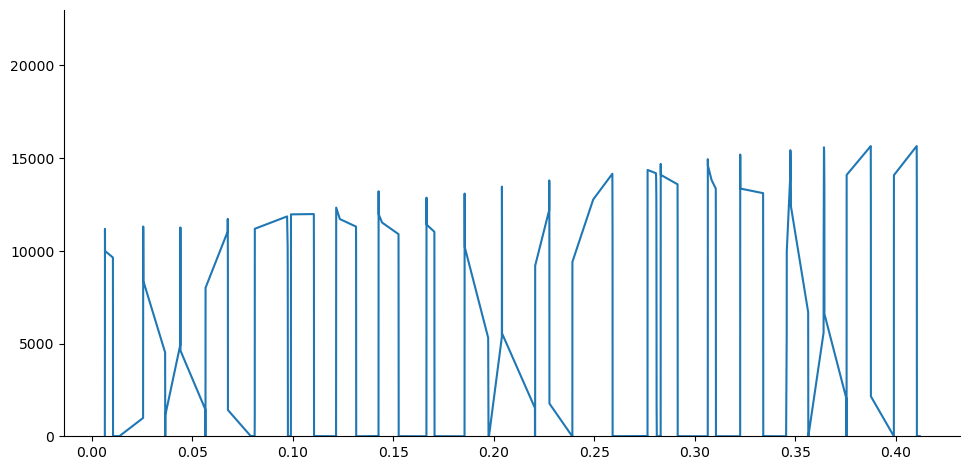

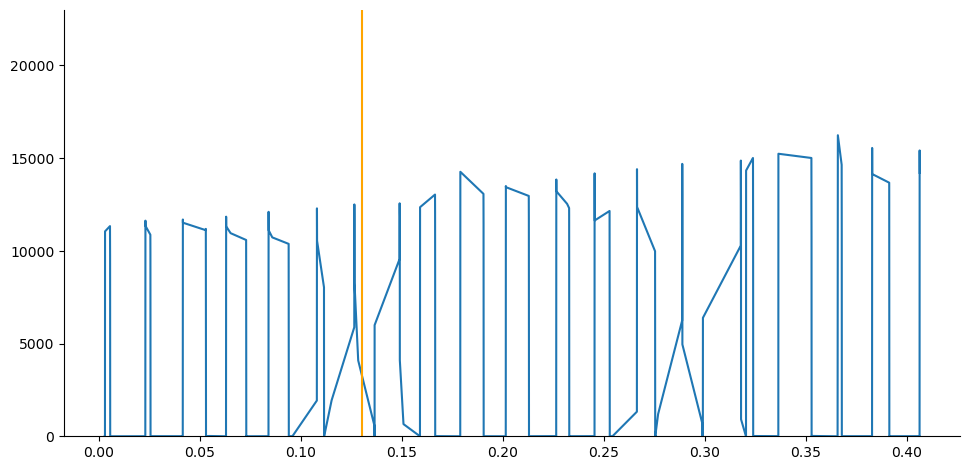

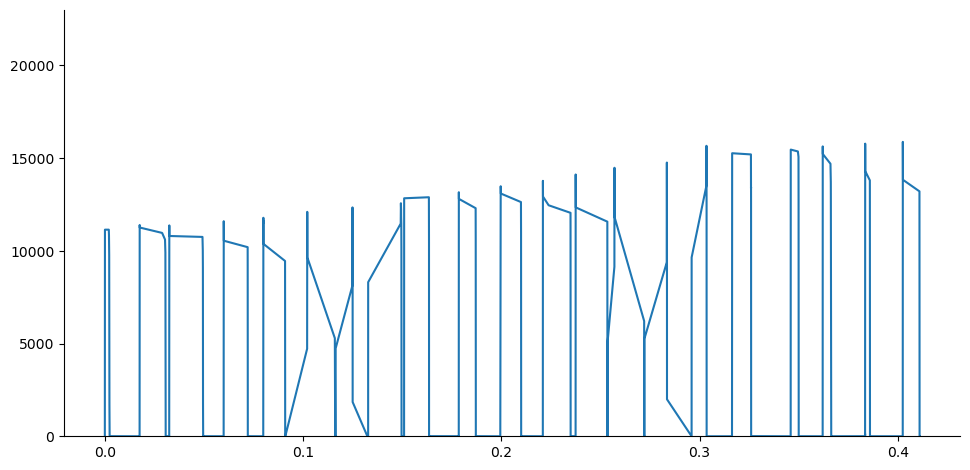

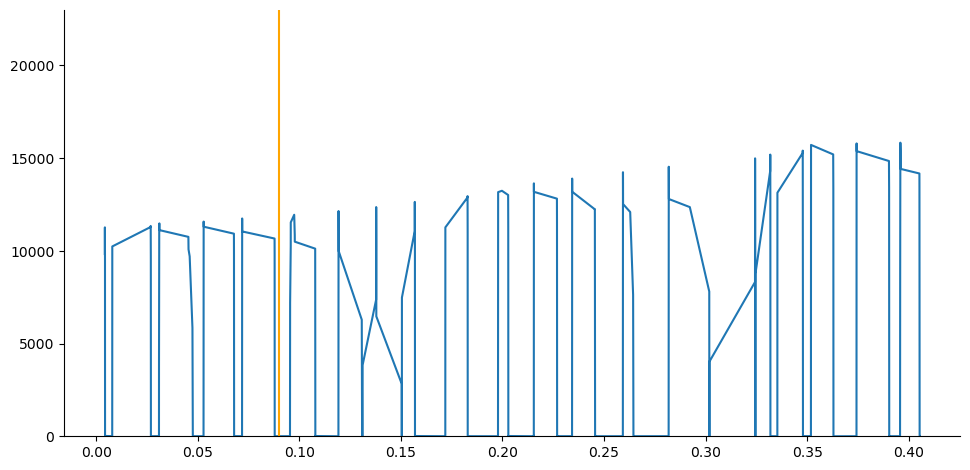

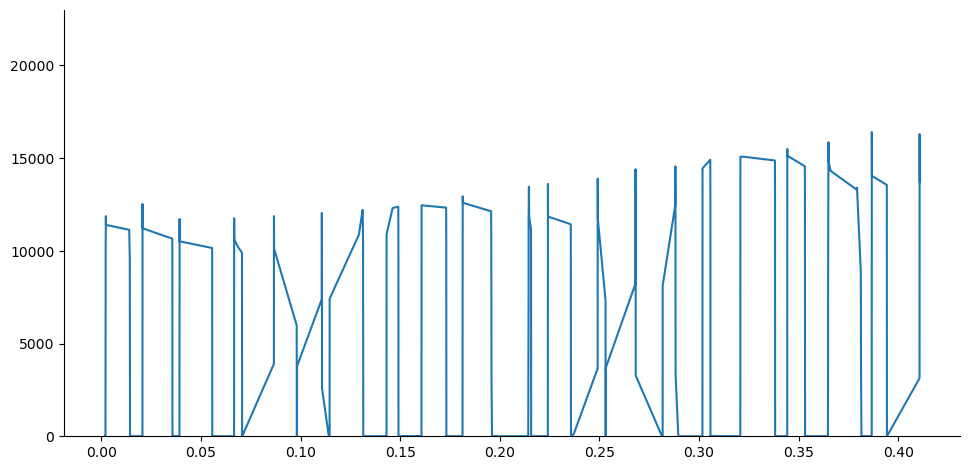

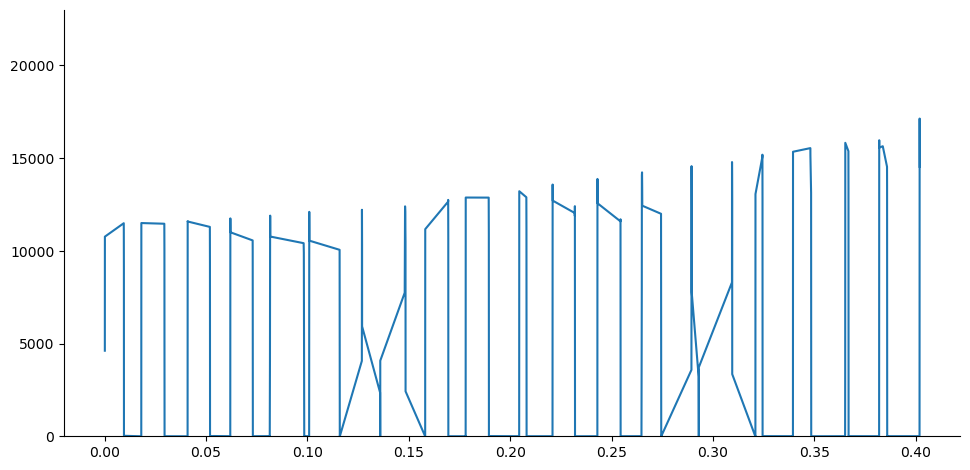

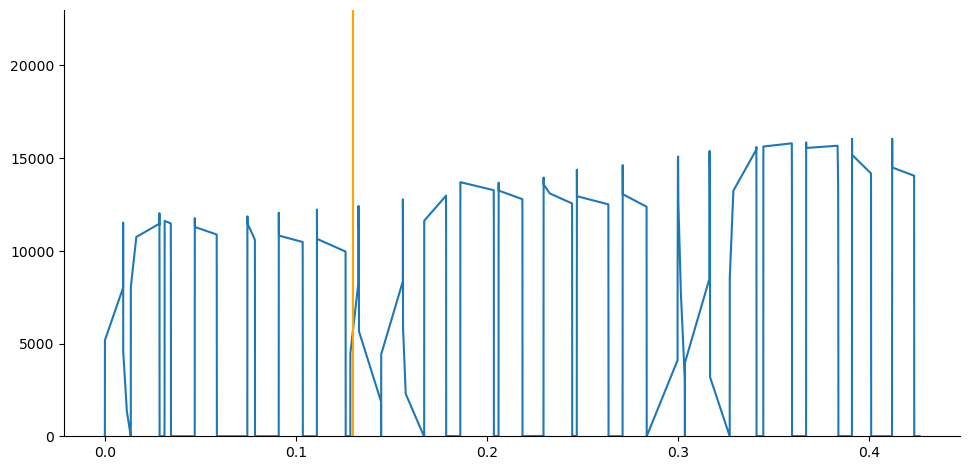

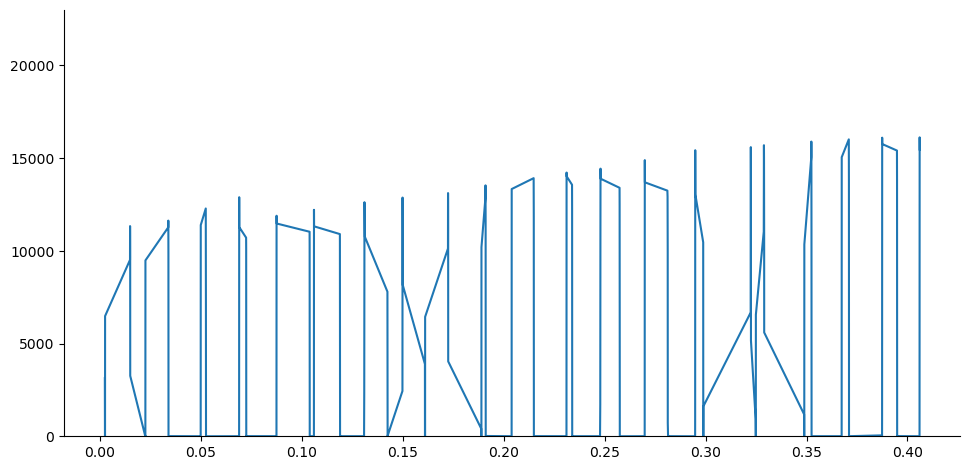

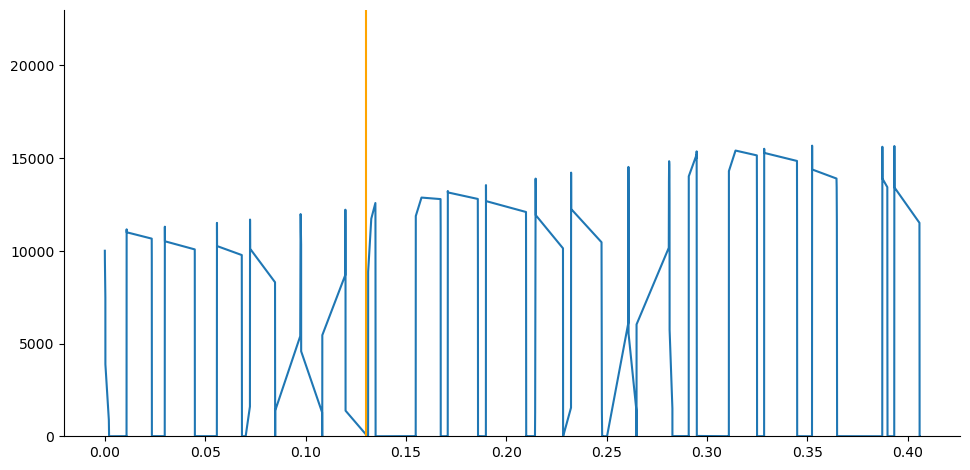

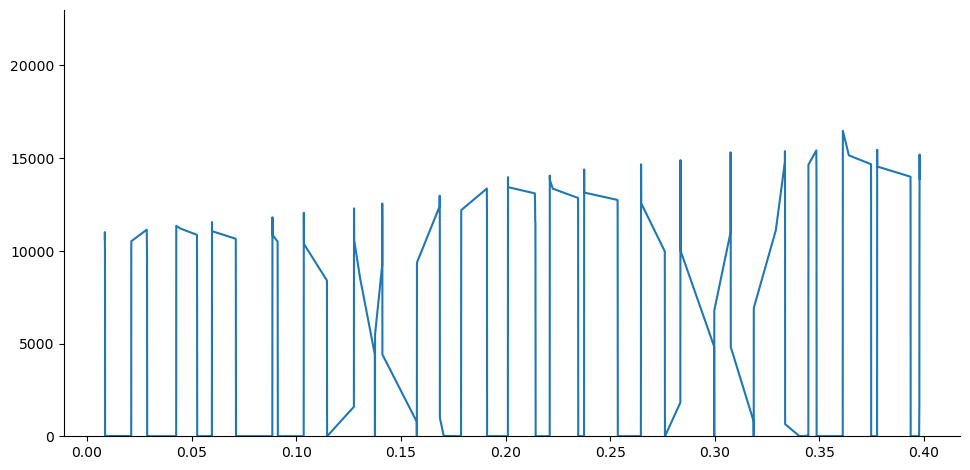

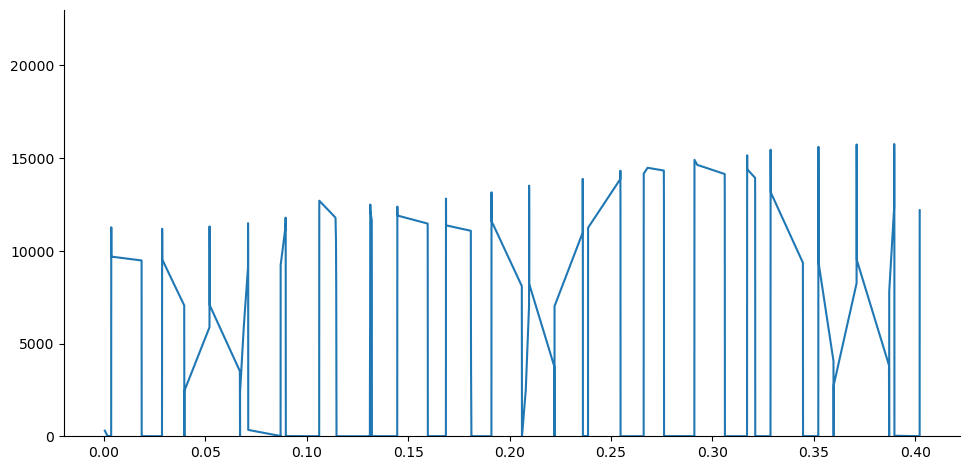

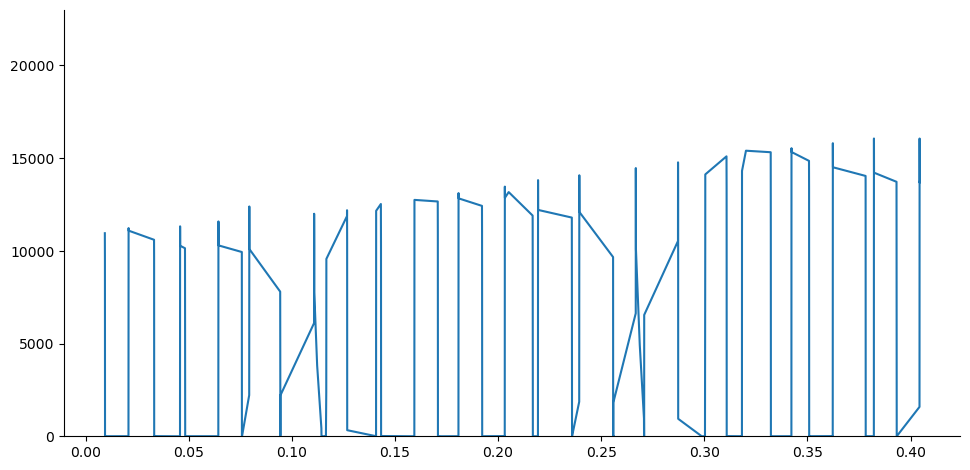

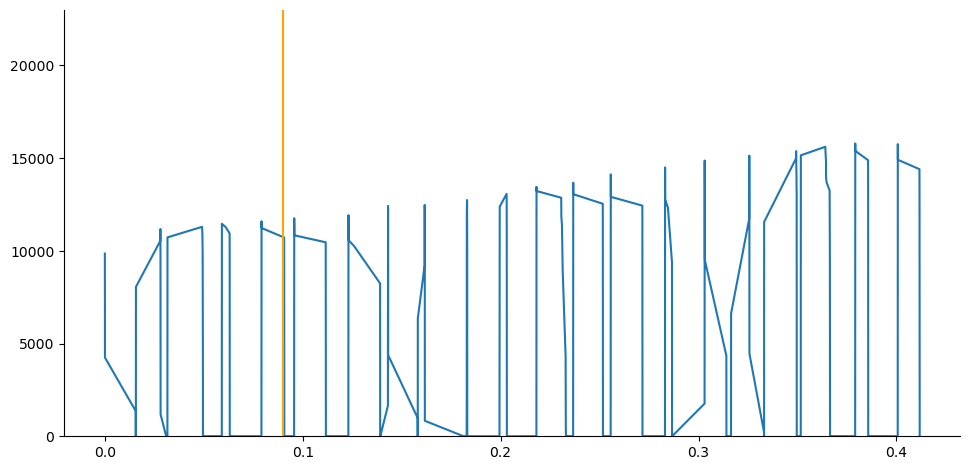

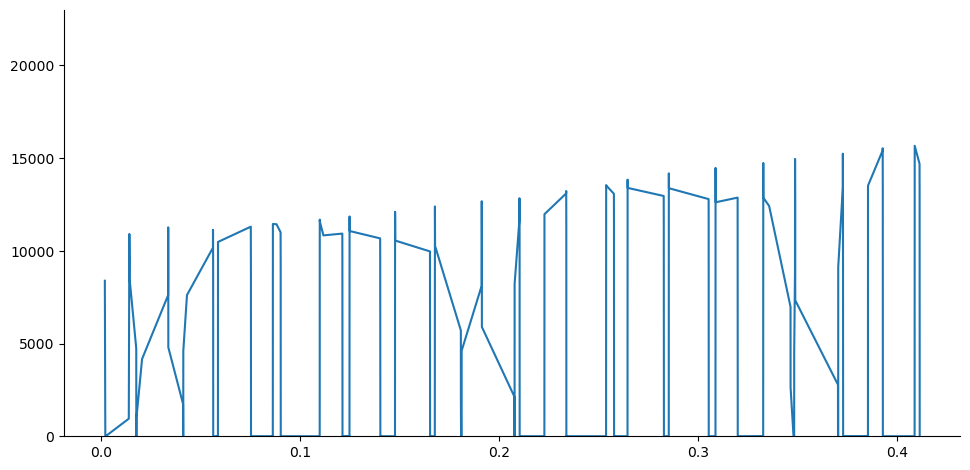

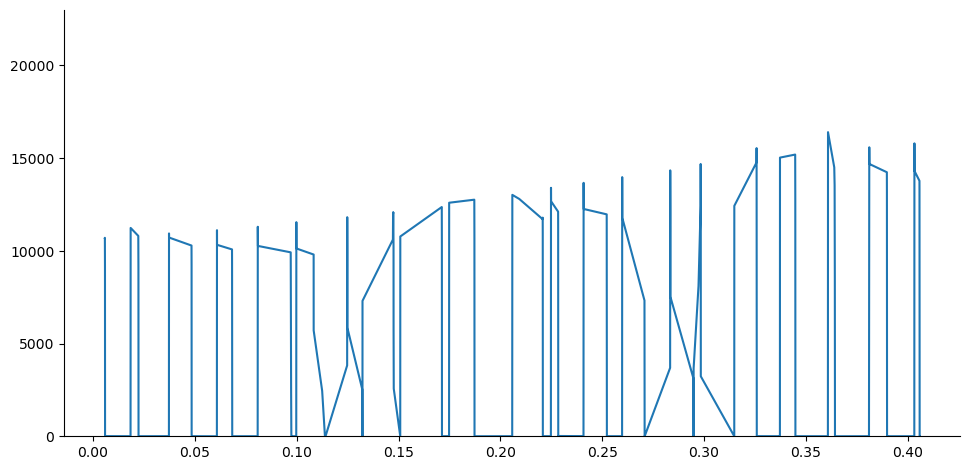

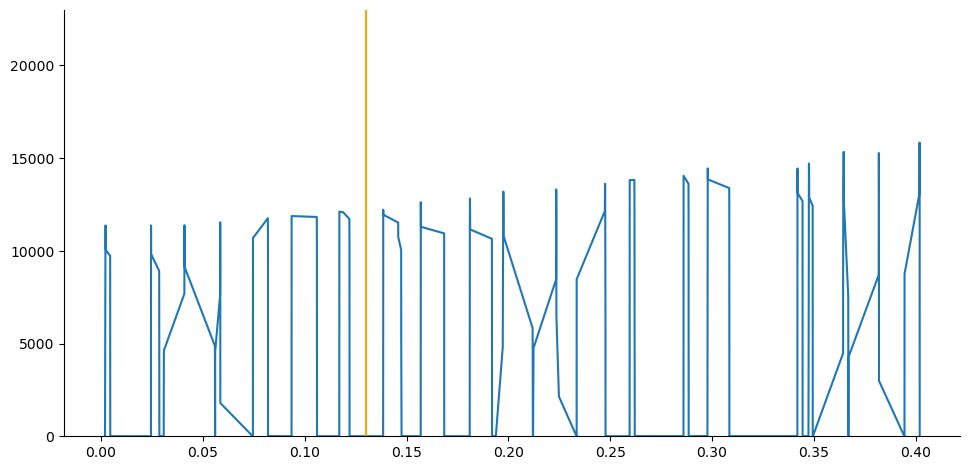

In [10]:
# Loes data (NICHT GEEIGNET FÜR neue DATEN)
block_nr, trial_nr = -1, 0
while(trial_nr < 300):
    trial_nr += 1
    if trial_nr % 20 == 1:
        block_nr += 1
        
    if trial_nr < 20 or trial_nr > 40:
        continue
        
    t_data = pd.read_csv(f"../copy from loes/data/loes_data_{block_nr}_{trial_nr}.csv")
    path_x = ast.literal_eval(t_data["eeg_forward_timestamps"][0])
    path_y = ast.literal_eval(t_data["eeg_forward"][0])
    
    t_plt = sb.relplot(kind="line", x=path_x, y=path_y, aspect=2, label="EDA")
    t_plt.set(ylim=(0,23000))
    if t_data['trial_burst_time'][0] != 0:
        plt.axvline(x=t_data['trial_burst_time'][0], color='orange', label="burst_time")

## PR and Force

In [11]:
trials_pr_answer = (trials[['trial_burst_force', 'pr_distance','subj_answer']][trials['subj_answer'].notnull()])
#trials_pr_answer['trial_burst_force'] = trials_pr_answer['trial_burst_force'].abs()
trials_pr_answer_bin = trials_pr_answer.copy()
trials_pr_answer_bin["trial_burst_force"] = trials_pr_answer_bin.trial_burst_force.apply(lambda x: 1 if x != 0 else 0)

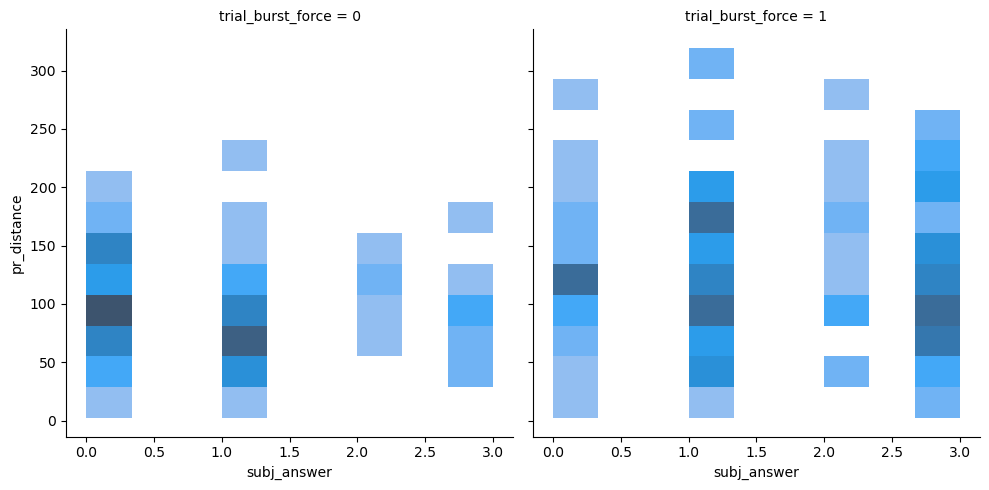

In [12]:
sb.displot(data=trials_pr_answer_bin, x="subj_answer", y="pr_distance", col="trial_burst_force")

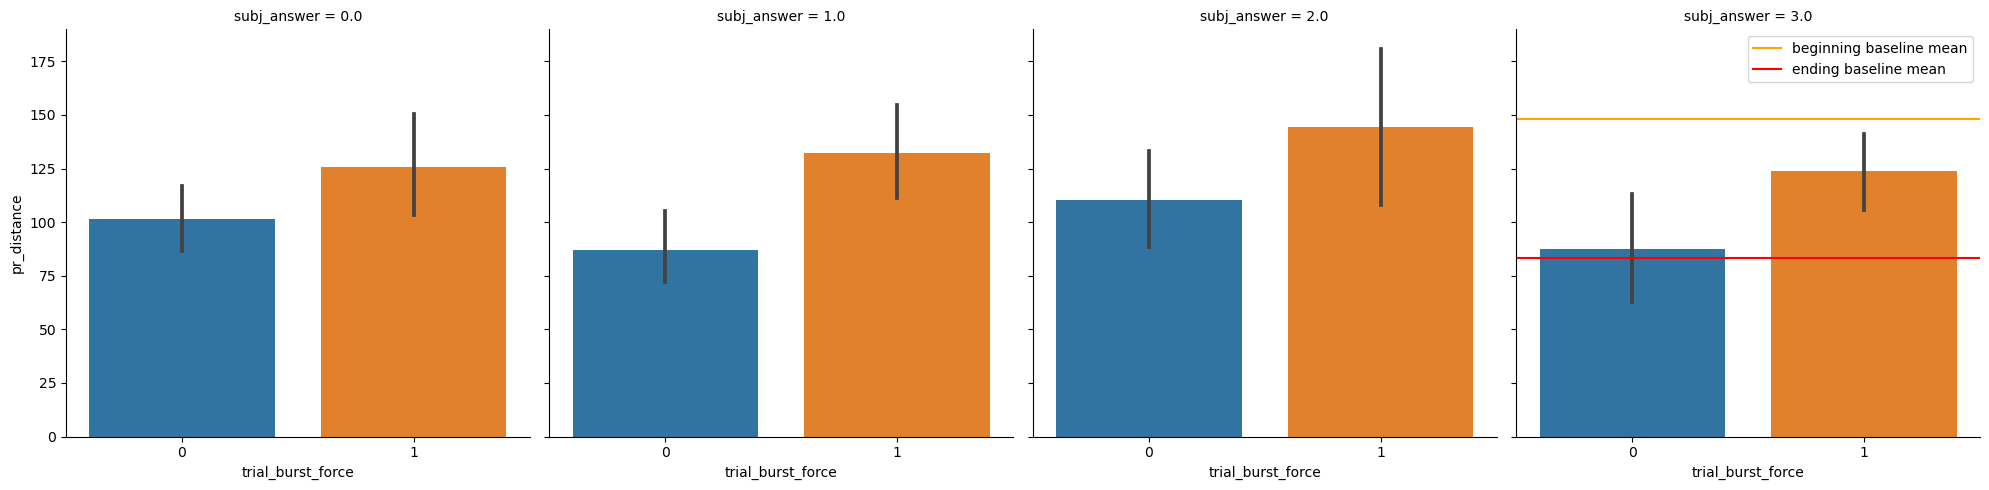

In [13]:
# Vergleichen von pr_dist normal mit pr_dist unter force

axes = sb.catplot(data=trials_pr_answer_bin, kind="bar", x="trial_burst_force", y="pr_distance", col="subj_answer")

base1 = pd.read_csv("./data/celine/beginn/trials.csv")
base1_mean = base1["pr_distance"].mean()
base2 = pd.read_csv("./data/celine/end/trials.csv")
base2_mean = base2["pr_distance"].mean()

plt.axhline(y=base1_mean, color="orange", label="beginning baseline mean")
plt.axhline(y=base2_mean, color="red", label="ending baseline mean")
plt.legend()

## PR over time

[(0.0, 400.0), Text(0.5, 1.0, 'Click-Task during training phase2')]

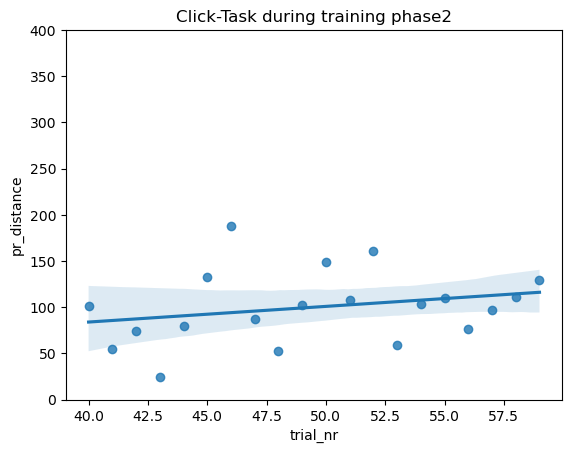

In [26]:
# PR during training(phase2)
trials_t2 = pd.read_csv("./data/celine/train2/trials.csv")
d = sb.regplot(data=trials_t2, x='trial_nr', y="pr_distance")#, kind="line")
d.set(ylim=(0,400), title="Click-Task during training phase2")

[(0.0, 400.0), Text(0.5, 1.0, 'Click-task baseline after task')]

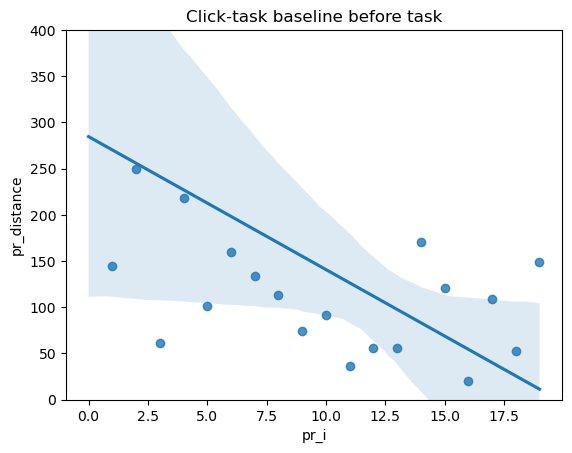

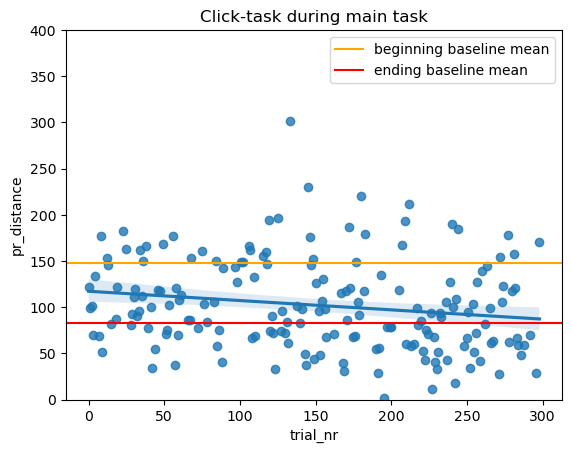

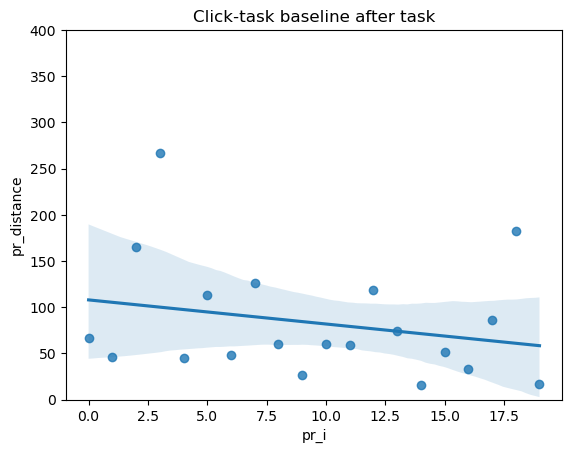

In [25]:
plt.figure(0)
a = sb.regplot(data=base1, x='pr_i', y="pr_distance")#, kind="line")
a.set(ylim=(0,400), title="Click-task baseline before task")
plt.figure(2)
d = sb.regplot(data=trials[trials["trial_burst_force"] == 0], x='trial_nr', y="pr_distance")#, kind="line")
d.set(ylim=(0,400), title="Click-task during main task")
plt.axhline(y=base1_mean, color="orange", label="beginning baseline mean")
plt.axhline(y=base2_mean, color="red", label="ending baseline mean")
plt.legend()
plt.figure(1)
b = sb.regplot(data=base2, x='pr_i', y="pr_distance")#, kind="line")
b.set(ylim=(0,400), title="Click-task baseline after task")

## PR targets

In [16]:
# TODO

## Questionnaire and subj answer

In [17]:
# res_force_answer_spearmanr.statistic?
avg_subj_answer = trials[trials['trial_burst_force'] != 0]['subj_answer'].mean()
avg_subj_answer_no_burst = trials[trials['trial_burst_force'] == 0]['subj_answer'].mean()
print(f"Normalized average subjective answer when no distortion happened: {avg_subj_answer_no_burst/4}")
print(f"Normalized average subjective answer when a distortion happened: {avg_subj_answer/4}")

quest2 = pd.read_csv("./data/celine/2_questionnaire.csv")
sss, spq = quest2[1:10], quest2[11:]
avg_sss = sss['response'].mean()
avg_spq = spq['response'].mean()
print(f"Normalized average susceptibility score: {avg_sss/4}")
print(f"Normalized average SPQ score: {avg_spq/3}")
print(f"Combined normalized average questionnaire score: {(avg_sss/4 + avg_spq/3)/2}")

# TODO: correlation over all participants

Normalized average subjective answer when no distortion happened: 0.21621621621621623
Normalized average subjective answer when a distortion happened: 0.4041666666666667
Normalized average susceptibility score: 0.4444444444444444
Normalized average SPQ score: 0.5333333333333333
Combined normalized average questionnaire score: 0.4888888888888889
